# README
This is a simple cleaner of data for the tweets that we have collected and classified. We are trying to get two key things:

- Classification
- Tweet itself

In order to do this we will see what we can do with pandas.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Chicago4C and UC-Irvine
old_cat = pd.read_csv('categorized_tweets.csv', encoding = "ISO-8859-1")
old_cat = old_cat[['Category', 'Tweet']]

In [3]:
# Boston
bos_tweets = pd.read_csv('twitter-data-4c/Boston4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
bos_tweets = bos_tweets[[2, 1]]
bos_tweets.columns = ['Category', 'Tweet']

# Brisbane
bris_tweets = pd.read_csv('twitter-data-4c/Brisbane4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
bris_tweets = bris_tweets[[2, 1]]
bris_tweets.columns = ['Category', 'Tweet']

# Dublin
dub_tweets = pd.read_csv('twitter-data-4c/Dublin4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
dub_tweets = dub_tweets[[2, 1]]
dub_tweets.columns = ['Category', 'Tweet']

# London
lon_tweets = pd.read_csv('twitter-data-4c/London4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
lon_tweets = lon_tweets[[2, 1]]
lon_tweets.columns = ['Category', 'Tweet']

# Memphis
mem_tweets = pd.read_csv('twitter-data-4c/Memphis4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
mem_tweets = mem_tweets[[2, 1]]
mem_tweets.columns = ['Category', 'Tweet']

# New York City
nyc_tweets = pd.read_csv('twitter-data-4c/NYC4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
nyc_tweets = nyc_tweets[[2, 1]]
nyc_tweets.columns = ['Category', 'Tweet']

# Seattle
sea_tweets = pd.read_csv('twitter-data-4c/Seattle4Classes.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
sea_tweets = sea_tweets[[2, 1]]
sea_tweets.columns = ['Category', 'Tweet']

# Sydney
syd_tweets = pd.read_csv('twitter-data-4c/Sydney4C.csv', encoding = "ISO-8859-1", delimiter = ';', header = None)
syd_tweets = syd_tweets[[2, 1]]
syd_tweets.columns = ['Category', 'Tweet']

In [4]:
# New tweets pulled by Henry
#chi_geo = pd.read_csv('fire-dept-geocode.csv', encoding = "ISO-8859-1", delimiter = ',')
pulled_fire_related = pd.read_csv('fire-dept.csv', encoding = "ISO-8859-1")
pulled_fire_related = pulled_fire_related[['category', 'text']]
pulled_fire_related.columns = ['Category', 'Tweet']

In [5]:
# Creating 1 dataframe and making it a csv
tweet_list = list([old_cat, bos_tweets, bris_tweets, dub_tweets, lon_tweets, mem_tweets, nyc_tweets,
             sea_tweets, syd_tweets, pulled_fire_related])

df = pd.concat(tweet_list).reset_index()
df = df[['Category', 'Tweet']]
df.Category = df.Category.str.upper()
df = df[(df.Category == 'FIRE') | (df.Category == 'NO')].reset_index()
df = df[['Category', 'Tweet']]

In [6]:
col = ["Category", "Tweet"]
df = df[col]
df.columns = ['Category', 'Tweet']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

,Category,Tweet,category_id
0,FIRE,Firefighters battle a two-alarm blaze at 54 Ma...,0
1,FIRE,Pray for Fort McMurray \n#forrestfire #cl415 #...,0
2,FIRE,Addison and McGraw. E42X stretched. #fourthofj...,0
3,FIRE,With fire season starting my brother is a hots...,0
4,FIRE,These Forrest fires are OUT OF CONTROL! ðð...,0


In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,4))
df.groupby('Category').Tweet.count().plot.bar(ylim=0)
plt.ylabel('Number of Tweets')
plt.title('Twitter Posts by Category')
plt.xticks(rotation = 0)
plt.rcParams.update({'font.size': 9})
plt.savefig('tweets_by_category.jpg')
plt.show()

<Figure size 800x400 with 1 Axes>

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Tweet).toarray()
labels = df.category_id
features.shape

(17298, 7673)

In [9]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
X = df.Tweet
y = df.Category

count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

In [11]:
# Creating the stratified training and test sets
for train_index, test_index in split.split(X_vect, y):
    X_train, X_test = X_vect[train_index], X_vect[test_index]
    y_train, y_test = y[train_index], y[test_index]

`CountVectorizer()` implements both tokenization and occurrence counting in a single class. We give each word its own integer representation and count how many times a token occurs.

Many words are not important in the analysis of text. A `TfidfTransformer()` reweights the words/tokens in the vectorized tweets. "Tf" means term-frequency and "idf" means inverse document frequency.

${tfidf}(t,d) = {tf}(t,d) * {idf}(t)$

The term frequency, the number of times a term occurs in a given document, is multiplied with idf component, which is computed as:

${idf}(t) = log \frac{1+n}{1+{df}(t)} + 1$

where where $n$ is the total number of documents in the document set, and $df(t)$ is the number of documents in the document set that contain term. The resulting tf-idf vectors are then normalized by the Euclidean norm:

$v_{norm} = \frac{\mathbf{v}}{{||\mathbf{v}||}_2}$

We did use Tf-Idf correction for smoothing, which adds “1” to the numerator and denominator as if an extra document was seen containing every term in the collection exactly once, which prevents zero divisions:

In [12]:
# Defaults: TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False) 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf = tfidf_transformer.fit_transform(X_test)
print(X_train_tfidf[0])

  (0, 32156)	0.5054438738537189
  (0, 31791)	0.15684855430650183
  (0, 27262)	0.2304659627633743
  (0, 16046)	0.41923934791083695
  (0, 14421)	0.527161348731629
  (0, 11109)	0.20815548148998772
  (0, 6640)	0.4120934827143895


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Previous Work
First we will try the model with our defaults:

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state = 42),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state = 42),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

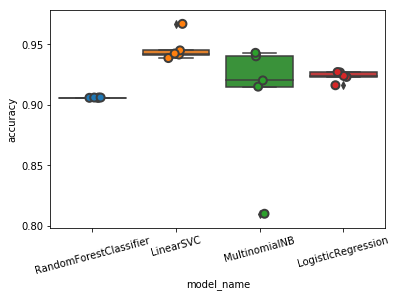

In [15]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
#plt.figure(figsize=(20,20))
plt.rcParams["figure.figsize"] = [10,10]
plt.xticks(rotation = 15)
plt.rcParams.update({'font.size': 14})
plt.savefig('results_large_text.png')
plt.show()

# Playing with the Random Forest

In [16]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
param_distribs = {
        'n_estimators': randint(low = 1, high = 500),
        'max_depth': randint(low = 1, high = 5),
        'max_features': randint(low = 1, high = 10)
    }

forest_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                                n_iter=25, cv=5, scoring=None, random_state=42)
rnd_search.fit(X_train_tfidf, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=25, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FB4D5BE5F8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FB4F2CA320>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FB4DF1EE48>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [18]:
mean_train_scores = rnd_search.cv_results_['mean_train_score']
index = np.argmax(mean_train_scores)
print(rnd_search.cv_results_['params'][index])

{'max_depth': 3, 'max_features': 4, 'n_estimators': 349}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [19]:
# Fitting the best randomly searched random forest 
from sklearn.metrics import accuracy_score

brf_clf = RandomForestClassifier(max_depth = 3, max_features = 4, n_estimators = 436, random_state = 42)
brf_clf.fit(X_train_tfidf, y_train)
y_pred = brf_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9060693641618497

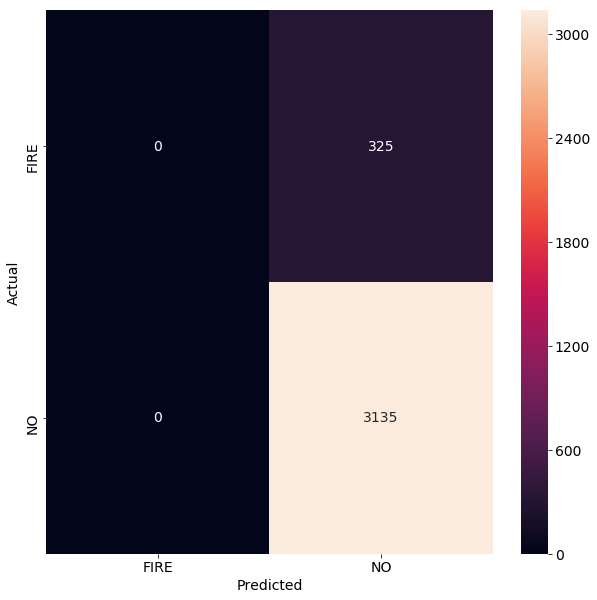

In [20]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('rf_confusion.png')
plt.show()

This is not good for results. It's **really** bad overfitting towards the `NO` class.

In [21]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

        FIRE       0.00      0.00      0.00       325
          NO       0.91      1.00      0.95      3135

   micro avg       0.91      0.91      0.91      3460
   macro avg       0.45      0.50      0.48      3460
weighted avg       0.82      0.91      0.86      3460



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# LinearSVC
Will this be a better binary classifier?

In [22]:
param_distribs = {
        'C': randint(low = 1, high = 100),
    }
lsvc_clf = LinearSVC(random_state=42, max_iter = 100000)
rnd_search = RandomizedSearchCV(lsvc_clf, param_distributions=param_distribs,
                                n_iter=25, cv=5, scoring=None, random_state=42)
rnd_search.fit(X_train_tfidf, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
          fit_params=None, iid='warn', n_iter=25, n_jobs=None,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FB4DF68438>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [23]:
mean_train_scores = rnd_search.cv_results_['mean_train_score']
index = np.argmax(mean_train_scores)
print(rnd_search.cv_results_['params'][index])

{'C': 52}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [32]:
from sklearn.metrics import accuracy_score

blsvc_clf = LinearSVC(C = 52, random_state = 42, max_iter = 100000)
blsvc_clf.fit(X_train_tfidf, y_train)
y_pred_lsvc = blsvc_clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred)

0.9791907514450867

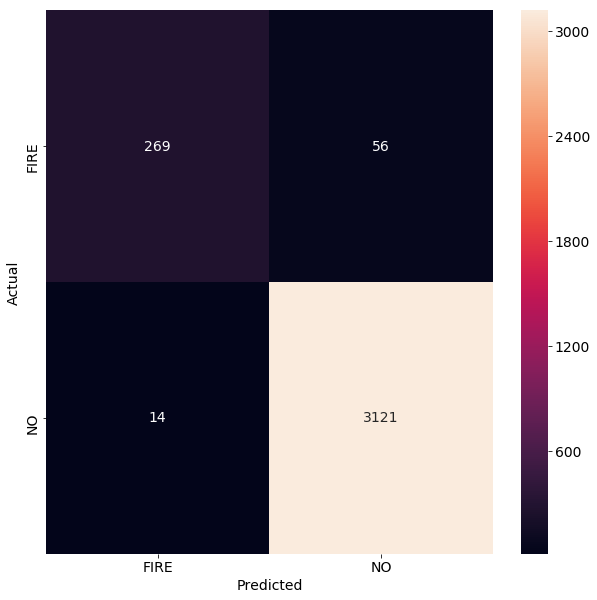

In [33]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_lsvc)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('lsvc_confusion.png')
plt.show()

In [34]:
print(metrics.classification_report(y_test, y_pred_lsvc, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

        FIRE       0.95      0.83      0.88       325
          NO       0.98      1.00      0.99      3135

   micro avg       0.98      0.98      0.98      3460
   macro avg       0.97      0.91      0.94      3460
weighted avg       0.98      0.98      0.98      3460



This performed significantly better, and we did not even attempt to use the string kernel trick.
# Logistic Classifier
Give this a try:

In [37]:
param_distribs = {
        'C': randint(low = 0, high = 1000),
    }

# Could potentially change penalty : str, ‘l1’, ‘l2’, ‘elasticnet’ or ‘none’, optional (default=’l2’)

log_clf = LogisticRegression(random_state=42, max_iter = 1000)
rnd_search = RandomizedSearchCV(log_clf, param_distributions=param_distribs,
                                n_iter=25, cv=5, scoring=None, random_state=42)
rnd_search.fit(X_train_tfidf, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=25, n_jobs=None,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FB4E371278>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [38]:
mean_train_scores = rnd_search.cv_results_['mean_train_score']
index = np.argmax(mean_train_scores)
print(rnd_search.cv_results_['params'][index])

{'C': 435}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [40]:
blog_clf = LogisticRegression(C = 435, random_state = 42, max_iter = 1000)
blog_clf.fit(X_train_tfidf, y_train)
y_pred_log = blog_clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred)

0.9791907514450867

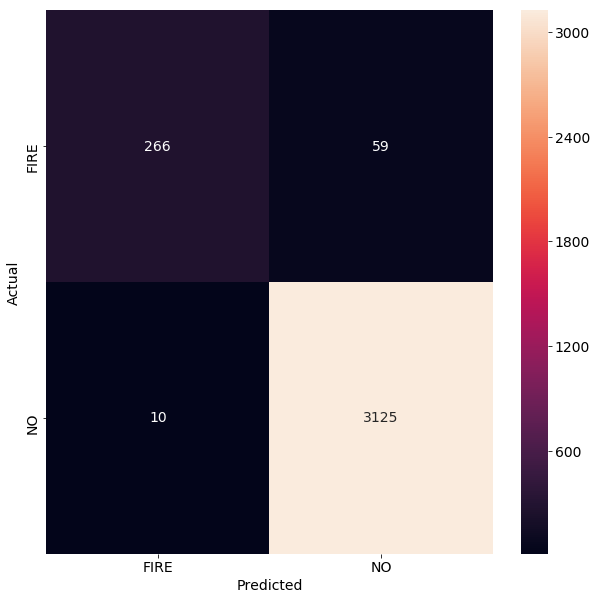

In [41]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_log)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('log_confusion.png')
plt.show()

In [42]:
print(metrics.classification_report(y_test, y_pred_log, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

        FIRE       0.96      0.82      0.89       325
          NO       0.98      1.00      0.99      3135

   micro avg       0.98      0.98      0.98      3460
   macro avg       0.97      0.91      0.94      3460
weighted avg       0.98      0.98      0.98      3460



# Multinomial Bayes
Last one:

In [43]:
param_distribs = {
        'alpha': randint(low = 0, high = 50),
    }
mnb_clf = MultinomialNB()
rnd_search = RandomizedSearchCV(mnb_clf, param_distributions=param_distribs,
                                n_iter=25, cv=5, scoring=None, random_state=42)
rnd_search.fit(X_train_tfidf, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          fit_params=None, iid='warn', n_iter=25, n_jobs=None,
          param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FB4E59C748>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [44]:
mean_train_scores = rnd_search.cv_results_['mean_train_score']
index = np.argmax(mean_train_scores)
print(rnd_search.cv_results_['params'][index])

{'alpha': 1}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [45]:
# The default value was choosen
bmnb_clf = MultinomialNB(alpha = 1)
bmnb_clf.fit(X_train_tfidf, y_train)
y_pred_nb = blog_clf.predict(X_test_tfidf)
accuracy_score(y_test, y_pred_nb)

0.9800578034682081

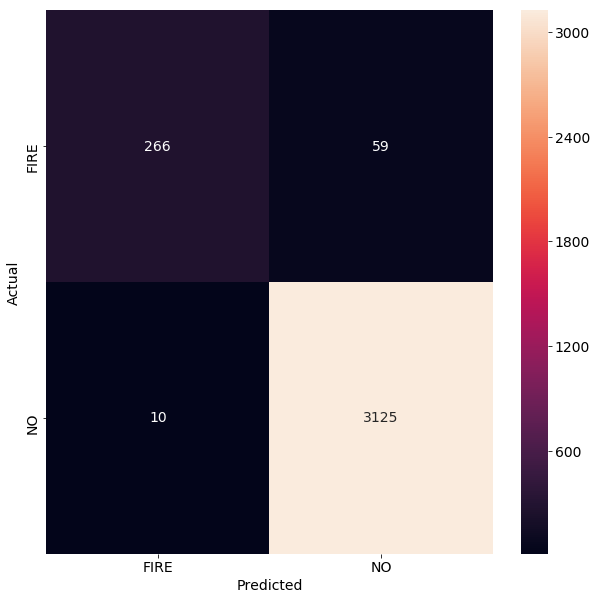

In [46]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_nb)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('mnb_confusion.png')
plt.show()

In [47]:
print(metrics.classification_report(y_test, y_pred_nb, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

        FIRE       0.96      0.82      0.89       325
          NO       0.98      1.00      0.99      3135

   micro avg       0.98      0.98      0.98      3460
   macro avg       0.97      0.91      0.94      3460
weighted avg       0.98      0.98      0.98      3460



In [53]:
from sklearn.ensemble import VotingClassifier

bmnb_clf = MultinomialNB(alpha = 1)

voting_clf = VotingClassifier(
    estimators = [('lr', blog_clf), ('mnb', bmnb_clf), ('svc', blsvc_clf)],
    voting = 'hard')

for clf in (blog_clf, blsvc_clf, bmnb_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression 0.976878612716763
LinearSVC 0.9728323699421966
MultinomialNB 0.9598265895953757


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


VotingClassifier 0.9765895953757225


In [54]:
y_pred = voting_clf.predict(X_test)

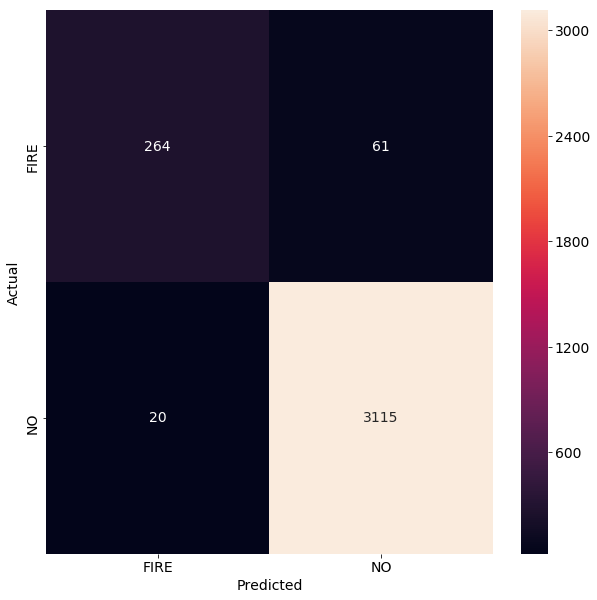

In [55]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('voting_confusion.png')
plt.show()

In [56]:
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

        FIRE       0.93      0.81      0.87       325
          NO       0.98      0.99      0.99      3135

   micro avg       0.98      0.98      0.98      3460
   macro avg       0.96      0.90      0.93      3460
weighted avg       0.98      0.98      0.98      3460

